Use ml.m5.4xlarge and DataScience 2.0 Python 3

In [2]:
# !pip install -q transformers>=4.25.1
# !pip install -q accelerate>=0.20.3
# !pip install -q datasets>=2.11
# !pip install -q evaluate>=0.3.0
# !pip install -q peft >=0.4.0
# !pip install torch==1.13.1
# !pip install wordcloud==1.9.3
# !pip install contractions


In [3]:
import pandas as pd
import numpy as np
import requests
import re
import os
import sys
import gzip
import json
import random
from tqdm import trange
import torch # PyTorch is a powerful deep learning library.
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from tabulate import tabulate
from sklearn.model_selection import train_test_split # for splitting data into train and test sets.
from sklearn.feature_extraction.text import TfidfVectorizer # for converting text data into vectors.
from sklearn.svm import SVC # Support Vector Machine Classifier model.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score 
# above line imports different metrics to evaluate the model performance.
from sklearn.naive_bayes import MultinomialNB # Multinomial Naive Bayes model.
from sklearn.ensemble import RandomForestClassifier # Random Forest Classifier model.
from sklearn.metrics import classification_report # for generating a comprehensive report of model performance.
from datasets import load_dataset 
# This function allows loading dataset from Huggingface's datasets library. 
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, TrainingArguments, Trainer, BertForSequenceClassification

# [Load the dataset](#Methodology)

In this step we will load the dataset into a pandas DataFrame, and explore it to understand its structure, format, and attributes in order to identify the specific column(s) or attribute(s) that contain the textual data that we will be will be working with. This dataset will be loaded from huggingface

In [4]:
import pandas as pd

# Read the CSV files
fake_news_articles = pd.read_csv('data/Fake.csv')
true_news_articles = pd.read_csv('data/True.csv')

# Assign labels: 0 for fake, 1 for true
fake_news_articles['label'] = 0
true_news_articles['label'] = 1

# Combine the two DataFrames into one
frames = [fake_news_articles, true_news_articles]
news_df = pd.concat(frames)

# Display the first few rows of the combined DataFrame
print(news_df.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  


### News dataset

In [5]:
print(news_df.head(),"\n\n")
print("Unique labels",news_df.label.unique())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0   


Unique labels [0 1]


**Result** 

- The train and test datasets target `labels` correspond to `0 - Negative` and `1 - Positive` and a `text` field.

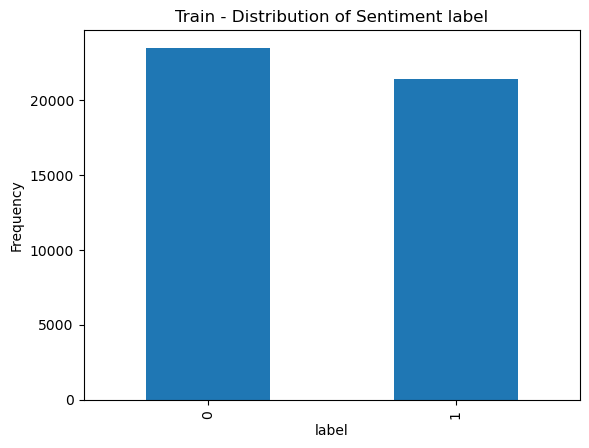

In [6]:
news_df['label'].value_counts().plot(kind='bar')
plt.title('Train - Distribution of Sentiment label')
plt.ylabel('Frequency')
plt.show()

**Result**

- The IMDB dataset has a even distribution of positive and negative reviews

### Print a random row above 95% percentile

In [7]:
# Get a random row from the dataframe
# Get the row above 95% percentile of the column news_df["Phrase"]
long_row = news_df[news_df["text"].str.len() > news_df["text"].str.len().quantile(0.98)]

random_row = long_row.sample(n=1)

# Convert the row to JSON format
long_row_json = random_row.to_json(orient='records')

# Parse the JSON string to a python dict
random_row_dict = json.loads(long_row_json)

# Print the dict in pretty format
print(json.dumps(random_row_dict[0], indent=4))
Random_ID_value = random_row.index[0]

{
    "title": "HOW THE CLINTON\u2019S GOT RICH Off Donations From People Who Thought They Were Helping Poverty-Stricken Haiti Earthquake Victims [VIDE0]",
    "text": "In January 2015 a group of Haitians surrounded the New York offices of the Clinton Foundation. They chanted slogans, accusing Bill and Hillary Clinton of having robbed them of  billions of dollars.  Two months later, the Haitians were at it again, accusing the Clintons of duplicity, malfeasance, and theft. And in May 2015, they were back, this time outside New York s Cipriani, where Bill Clinton received an award and collected a $500,000 check for his foundation.  Clinton, where s the money?  the Haitian signs read.  In whose pockets?  Said Dhoud Andre of the Commission Against Dictatorship,  We are telling the world of the crimes that Bill and Hillary Clinton are responsible for in Haiti. Haitians like Andre may sound a bit strident, but he and the protesters had good reason to be disgruntled. They had suffered a heavy

In [8]:
print(Random_ID_value)

13120


**result**
- On printing random row we see that the text fields are not clean, we will perform data to clean up punctuations, stop words, ASCII characters, dates etc. 

### Text Length Analysis

Calculate the length of each review and analyze the distribution of lengths to garner insights into the average length of reviews, the trange of lengths, etc.

count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: text, dtype: float64


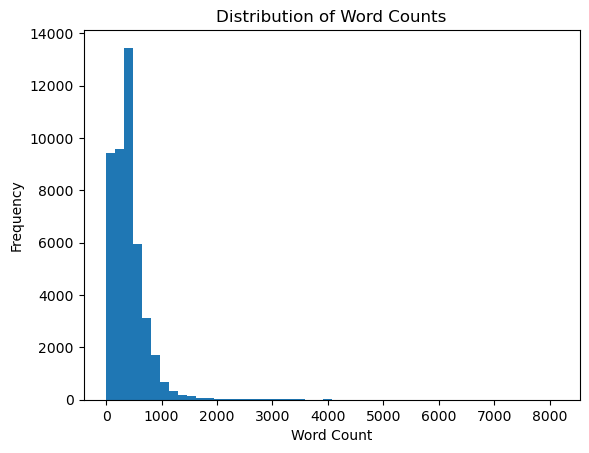

In [9]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Define a function to calculate word count
def word_count(text):
    return len(text.split())

# Print out a summary of the word count statistics
print(news_df['text'].apply(word_count).describe())

# Plot a histogram of the word counts
plt.hist(news_df['text'].apply(word_count), bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**Result**
- The distribution shows the word count tranges from 4 words to 2,278 with an average of 228 words and a standard deviation of 168.

# [Apply Word2vec for Semantec Analsyis, Key Word and Topic analsysis](#Methodology)

We will use word2vec for semantic analysis to perform keyword extraction and gain insights into the main topics and themes discussed in the reviews.

Word2vec represents words as vectors in a high-dimensional space, capturing their semantic relationships. This allows us to identify key words that are closely related to the main topics and themes in the reviews. This will help us extract more meaningful insights from the text data and overcome the limitations of using simple frequency-based methods like TF-IDF.


In [10]:
# Visualizing the Word cloud using Word2vec
from gensim.models import Word2Vec

# Fit and transform the reviews
reviews = news_df['text'].tolist()
reviews_tokenized = [review.split() for review in reviews]

# Train word2vec model
model = Word2Vec(sentences=reviews_tokenized, vector_size=100, window=5, min_count=1)

# Get word frequencies from the trained model
word_freq = {word: model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key}

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

**result**

- In our first pass at keyword analsisys, we find that the most common word were stop words, specifically `the` is the most common word followed by `and` and `of`. We will review this results after cleaning up the datasets

# [Cleaning the Dataset]((#Methodology))

In this section, we will perform text cleaning that will involve several processes. The first process is fixing contractions. Contractions are words or combinations of words that are shortened by dropping letters and replacing them with an apostrophe. For example, "don't" is a contraction of "do not". Fixing these contractions will ensure that our text data is consistent and easier to analyze. 

The next process is removing non-ASCII characters. ASCII characters are the standard characters in the English language, including all letters, numbers, and common symbols. Non-ASCII characters include special symbols and characters from other languages. Removing these will ensure that our text data only contains standard English characters.

The third process is converting all text to lowercase. This is important because in text analysis, 'Word' and 'word' are considered as two different words due to the difference in case. By converting everything to lowercase, we can avoid this issue and make our analysis more accurate.

The final process is removing punctuations. Punctuations can cause issues in text analysis as they can create different tokens or words. For example, 'word,' and 'word' would be considered as two different words due to the comma. By removing punctuations, we can avoid this issue and make our text data cleaner and easier to analyze.

### Contractions

We used the [contractions](https://github.com/kootenpv/contractions) package to resolve contractions and  (and slang), `examples:you're -> you are`



In [11]:
import contractions
news_df["text_clean"] = news_df['text'].apply(lambda x: contractions.fix(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'In January 2015 a group of Haitians surrounded the New York offices of the Clinton Foundation. They chanted slogans, accusing Bill and Hillary Clinton of having robbed them of  billions of dollars.  T'

### Remove URLs
Remove URL from text

In [12]:
def remove_URL(text):
    """
        Remove URLs from a sample string
    """
    return re.sub(r"https?://\S+|www\.\S+", "", text)
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_URL(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'In January 2015 a group of Haitians surrounded the New York offices of the Clinton Foundation. They chanted slogans, accusing Bill and Hillary Clinton of having robbed them of  billions of dollars.  T'

### Remove Non-ASCI Characters

In [13]:
def remove_non_ascii(text):
    """
        Remove non-ASCII characters 
    """
    return re.sub(r'[^\x00-\x7f]',r'', text) # or ''.join([x for x in text if x in string.printable]) 

news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_non_ascii(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'In January 2015 a group of Haitians surrounded the New York offices of the Clinton Foundation. They chanted slogans, accusing Bill and Hillary Clinton of having robbed them of  billions of dollars.  T'

### Make characters lowercase

In [14]:
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: x.lower())
news_df.iloc[Random_ID_value]['text_clean'][:200]

'in january 2015 a group of haitians surrounded the new york offices of the clinton foundation. they chanted slogans, accusing bill and hillary clinton of having robbed them of  billions of dollars.  t'

### Remove html

In [15]:
def remove_html(text):
    """
        Remove the html in sample text
    """
    html = re.compile(r"<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});")
    return re.sub(html, "", text)
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_html(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'in january 2015 a group of haitians surrounded the new york offices of the clinton foundation. they chanted slogans, accusing bill and hillary clinton of having robbed them of  billions of dollars.  t'

### Remove symbols

In [16]:
def remove_symbols(text):
    """
        Remove special special characters, including symbols, emojis, and other graphic characters
    """
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_symbols(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'in january 2015 a group of haitians surrounded the new york offices of the clinton foundation. they chanted slogans, accusing bill and hillary clinton of having robbed them of  billions of dollars.  t'

### Remove Special characters

In [17]:
def remove_special_chars(text):
    """
        Remove special characters (\n, \, ', "",) in sample text
    """
    # Replace \n, \ and ' with empty string
    text = text.replace('\n', ' ').replace('\\', ' ').replace('\'', ' ').replace('\"', ' ').replace('-', ' ').replace('(', ' ').replace(')', ' ')
    return text

# Assuming news_df is a DataFrame with a column "text_clean" containing text data
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_special_chars(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'in january 2015 a group of haitians surrounded the new york offices of the clinton foundation. they chanted slogans, accusing bill and hillary clinton of having robbed them of  billions of dollars.  t'

### Remove punctuations

In [18]:
import re
def remove_punct(text):

    # Replace punctuation with space, except for decimal points in numerical values
    return re.sub(r'(?:(?<!\d)[.,;()]|[.,;()](?!\d))', '', text)

# Apply the function to the dataframe
news_df["text_clean"] = news_df["text_clean"].apply(lambda x: remove_punct(x))
news_df.iloc[Random_ID_value]['text_clean'][:200]

'in january 2015 a group of haitians surrounded the new york offices of the clinton foundation they chanted slogans accusing bill and hillary clinton of having robbed them of  billions of dollars  two '

**result**
- In removing punctuations, we needed to be carefull not to remove punctuations in between numbers in order to preseve the information in text, doing so would have caused values such as `12.4 million` -> `124 million` which would have changed the meaning of the text

# [Text Preprocessing](#Methodology)

In this section, we will perform text preprocessing that will involve several steps. First, we will carry out tokenization on the textual data. This process involves splitting the text into individual tokens, which could be words, punctuation, or other meaningful units. We will use an appropriate tokenization technique or library to achieve this. 

Next, we will remove stop words from the tokenized text. Stop words are common words such as "the," "is," "and" that do not carry significant meaning. We will use a standard stop word list or library to identify and remove these words from our text. 

Following this, we will apply stemming to the tokens. Stemming is a process that reduces each word to its base or root form. We will use a suitable stemming algorithm or library to perform this task. 

Finally, we will implement lemmatization on the tokens. Lemmatization is a process that transforms each word into its canonical or dictionary form. We will use a reliable lemmatization technique or library for this purpose. 

### Tokenization

Tokenization is the process of breaking down text into smaller parts called tokens which help in understanding the context or developing the model for NLP (Natural Language Processing). The tokenization helps in interpreting the meaning of the text by analyzing the sequence of the words. 

For instance, consider the text "The quick brown fox jumps over the lazy dog". In tokenization, this sentence is broken down into individual words: 'The', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog'.

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
import nltk
from nltk.tokenize import word_tokenize

news_df['tokenized'] = news_df['text_clean'].apply(word_tokenize)
news_df.iloc[Random_ID_value]['tokenized'][:200]

['in',
 'january',
 '2015',
 'a',
 'group',
 'of',
 'haitians',
 'surrounded',
 'the',
 'new',
 'york',
 'offices',
 'of',
 'the',
 'clinton',
 'foundation',
 'they',
 'chanted',
 'slogans',
 'accusing',
 'bill',
 'and',
 'hillary',
 'clinton',
 'of',
 'having',
 'robbed',
 'them',
 'of',
 'billions',
 'of',
 'dollars',
 'two',
 'months',
 'later',
 'the',
 'haitians',
 'were',
 'at',
 'it',
 'again',
 'accusing',
 'the',
 'clintons',
 'of',
 'duplicity',
 'malfeasance',
 'and',
 'theft',
 'and',
 'in',
 'may',
 '2015',
 'they',
 'were',
 'back',
 'this',
 'time',
 'outside',
 'new',
 'york',
 's',
 'cipriani',
 'where',
 'bill',
 'clinton',
 'received',
 'an',
 'award',
 'and',
 'collected',
 'a',
 '$',
 '500,000',
 'check',
 'for',
 'his',
 'foundation',
 'clinton',
 'where',
 's',
 'the',
 'money',
 '?',
 'the',
 'haitian',
 'signs',
 'read',
 'in',
 'whose',
 'pockets',
 '?',
 'said',
 'dhoud',
 'andre',
 'of',
 'the',
 'commission',
 'against',
 'dictatorship',
 'we',
 'are',
 'te

**result**
- On tokenization, we find that `word_tokenize` does not catch numbers such as `175m` which represents 175 million. Since the NLP downstream task is sentiment, analysis these definitions of tokens are fine and can be left as is

### Remove stop words

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Removing stopwords.
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))
news_df['stopwords_removed'] = news_df['tokenized'].apply(lambda x: [word for word in x if word not in stop])
news_df.iloc[Random_ID_value]['stopwords_removed'][:200]

['january',
 '2015',
 'group',
 'haitians',
 'surrounded',
 'new',
 'york',
 'offices',
 'clinton',
 'foundation',
 'chanted',
 'slogans',
 'accusing',
 'bill',
 'hillary',
 'clinton',
 'robbed',
 'billions',
 'dollars',
 'two',
 'months',
 'later',
 'haitians',
 'accusing',
 'clintons',
 'duplicity',
 'malfeasance',
 'theft',
 'may',
 '2015',
 'back',
 'time',
 'outside',
 'new',
 'york',
 'cipriani',
 'bill',
 'clinton',
 'received',
 'award',
 'collected',
 '$',
 '500,000',
 'check',
 'foundation',
 'clinton',
 'money',
 '?',
 'haitian',
 'signs',
 'read',
 'whose',
 'pockets',
 '?',
 'said',
 'dhoud',
 'andre',
 'commission',
 'dictatorship',
 'telling',
 'world',
 'crimes',
 'bill',
 'hillary',
 'clinton',
 'responsible',
 'haiti',
 'haitians',
 'like',
 'andre',
 'may',
 'sound',
 'bit',
 'strident',
 'protesters',
 'good',
 'reason',
 'disgruntled',
 'suffered',
 'heavy',
 'blow',
 'mother',
 'nature',
 'appeared',
 'battered',
 'time',
 'clintons',
 'story',
 'goes',
 'back',
 

count    44898.000000
mean       240.672836
std        210.325345
min          0.000000
25%        123.000000
50%        212.000000
75%        302.000000
max       5107.000000
Name: word_count, dtype: float64


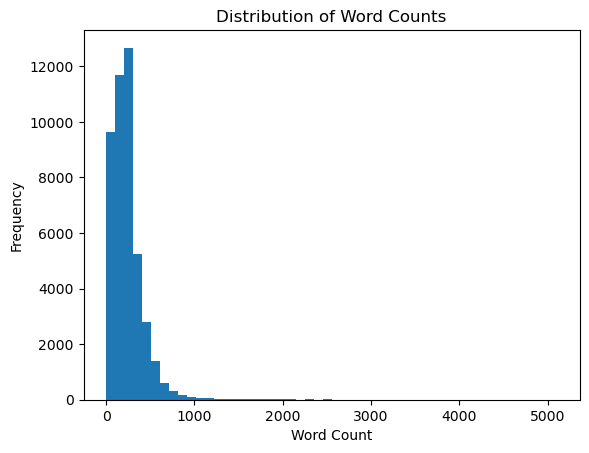

In [23]:
# Apply the join function to the 'stopwords_removed' column
news_df['word_count'] = news_df['stopwords_removed'].apply(' '.join).apply(word_count)

# Print out a summary of the word count statistics
print(news_df['word_count'].describe())

# Plot a histogram of the word counts
plt.hist(news_df['word_count'], bins=50)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

**result**
- After removing the stop words, maximum length of `text` goes from 4 to 1178 words. 

In [24]:
news_df.iloc[Random_ID_value]['stopwords_removed'][:200]

['january',
 '2015',
 'group',
 'haitians',
 'surrounded',
 'new',
 'york',
 'offices',
 'clinton',
 'foundation',
 'chanted',
 'slogans',
 'accusing',
 'bill',
 'hillary',
 'clinton',
 'robbed',
 'billions',
 'dollars',
 'two',
 'months',
 'later',
 'haitians',
 'accusing',
 'clintons',
 'duplicity',
 'malfeasance',
 'theft',
 'may',
 '2015',
 'back',
 'time',
 'outside',
 'new',
 'york',
 'cipriani',
 'bill',
 'clinton',
 'received',
 'award',
 'collected',
 '$',
 '500,000',
 'check',
 'foundation',
 'clinton',
 'money',
 '?',
 'haitian',
 'signs',
 'read',
 'whose',
 'pockets',
 '?',
 'said',
 'dhoud',
 'andre',
 'commission',
 'dictatorship',
 'telling',
 'world',
 'crimes',
 'bill',
 'hillary',
 'clinton',
 'responsible',
 'haiti',
 'haitians',
 'like',
 'andre',
 'may',
 'sound',
 'bit',
 'strident',
 'protesters',
 'good',
 'reason',
 'disgruntled',
 'suffered',
 'heavy',
 'blow',
 'mother',
 'nature',
 'appeared',
 'battered',
 'time',
 'clintons',
 'story',
 'goes',
 'back',
 

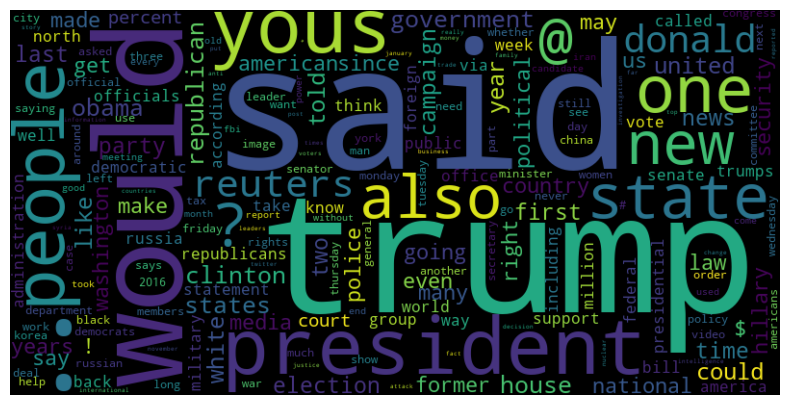

In [25]:
# Visualizing the Word cloud using Word2vec
from gensim.models import Word2Vec

# Fit and transform the reviews
reviews = news_df['stopwords_removed'].apply(' '.join).tolist()
reviews_tokenized = [review.split() for review in reviews]

# Train word2vec model
model = Word2Vec(sentences=reviews_tokenized, vector_size=100, window=5, min_count=1)

# Get word frequencies from the trained model
word_freq = {word: model.wv.get_vecattr(word, "count") for word in model.wv.index_to_key}

# Create a DataFrame for easy sorting and indexing
word_freq_df = pd.DataFrame.from_dict(word_freq, orient='index', columns=['frequency'])

# Sort by frequency
word_freq_df_sorted = word_freq_df.sort_values(by='frequency', ascending=False)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq_df_sorted['frequency'])

# Display the generated image:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


**result**
- After incoperating the stop word removal, we noticed that have a key words now related to `movie`, `film` , `one` and `good`. 

# [Train and test datasets](#Methodology)

In [26]:
### Import Models

In [27]:
# Tokenize
model_name='prajjwal1/bert-tiny'

tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=512)

/opt/conda/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [28]:
news_df["stopwords_removed"] = news_df["stopwords_removed"].apply(' '.join)

In [29]:
text = news_df['stopwords_removed']
labels = torch.from_numpy(np.array(news_df.label))

**BERT requires the following preprocessing steps**


Incorporate special tokens:
- Commence each sentence with a [CLS] token (identified as 101)
- Conclude each sentence with a [SEP] token (identified as 102)

Achieve uniform sentence lengths:
- Padding is employed to equalize shorter sequences to the required length by adding convenience values. Longer sequences are shortened.
- Padding tokens, known as [PAD], are recognized as ID 0.
- The permissible maximum sequence length is 512 tokens.

Develop an attention mask:
- A list of binary values (0s and 1s) indicating whether the model should take into account certain tokens while learning their contextual representation. Padding ([PAD]) tokens are expected to have a value of 0.
This process can be visualized as follows:  


<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*vaw98m1VVncgKxNFWI0d2Q.png" alt="drawing" width="800"/>

We will use a very helpfull function [encode_plus](https://huggingface.co/docs/transformers/main_classes/tokenizer?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus) provided in the Tokenizer class to procepcessing.


--- 

### Tokenization

In [30]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

/opt/conda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_17456/1155887400.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [31]:
def print_shortest_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of the shortest text sample'''
  
  # Get the length of each sentence in the dataset
  sentence_lengths = [len(s) for s in token_id]
  
  # Find the index of the shortest sentence
  shortest_index = np.argmin(sentence_lengths)
  
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[shortest_index]))
  token_ids = [i.item() for i in token_id[shortest_index]]
  attention = [i.item() for i in attention_masks[shortest_index]]

  table = np.array([tokens, token_ids, attention]).T[:180]
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_shortest_sentence_encoding()

╒════════════╤═════════════╤══════════════════╕
│ Tokens     │   Token IDs │   Attention Mask │
╞════════════╪═════════════╪══════════════════╡
│ [CLS]      │         101 │                1 │
├────────────┼─────────────┼──────────────────┤
│ donald     │        6221 │                1 │
├────────────┼─────────────┼──────────────────┤
│ trump      │        8398 │                1 │
├────────────┼─────────────┼──────────────────┤
│ wish       │        4299 │                1 │
├────────────┼─────────────┼──────────────────┤
│ americans  │        4841 │                1 │
├────────────┼─────────────┼──────────────────┤
│ happy      │        3407 │                1 │
├────────────┼─────────────┼──────────────────┤
│ new        │        2047 │                1 │
├────────────┼─────────────┼──────────────────┤
│ year       │        2095 │                1 │
├────────────┼─────────────┼──────────────────┤
│ leave      │        2681 │                1 │
├────────────┼─────────────┼────────────

# [Train and test datasets](#Methodology)

**I split the dataset into train (80%) and validation (20%) sets, and wrap them around a torch.utils.data.DataLoader object. DataLoader provides an object that we can use to iterateover the given dataset.**

In [32]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Set up some constants
VAL_RATIO = 0.2
BATCH_SIZE = 4

def split_dataset(token_id, attention_masks, labels):
    train_index, temp_index = train_test_split(
        np.arange(len(labels)), 
        test_size = 0.6,
        shuffle = True,
        stratify = labels
    )

    validate_index, production_index = train_test_split(
        temp_index,
        test_size = 2/3,
        shuffle = True,
        stratify = labels[temp_index]
    )

    return train_index, validate_index, production_index

**Loaded the data into Dataloader objects. We are using the PyTorch `DataLoader` method and using randomSampler to draw random samples from the dataset**

In [33]:
def load_data(train_index, validation_index):
    """
    Load the data into DataLoader objects.
    Returns DataLoaders for training and validation sets.
    """
    
    # Create TensorDatasets for training and validation sets
    train_set = TensorDataset(token_id[train_index], 
                              attention_masks[train_index], 
                              labels[train_index])
    
    val_set = TensorDataset(token_id[validation_index], 
                            attention_masks[validation_index], 
                            labels[validation_index])

    # Create DataLoaders for training and validation sets 
    # Training DataLoader uses RandomSampler to draw random samples from the dataset
    train_dataloader = DataLoader(
                train_set,
                sampler=RandomSampler(train_set),
                batch_size=BATCH_SIZE)

    
     # Validation DataLoader uses SequentialSampler to draw sequential samples from the dataset
    validate_dataloader = DataLoader(
                val_set,
                sampler=SequentialSampler(val_set),
                batch_size=BATCH_SIZE)
    
    return train_dataloader, validate_dataloader

**I calculate the mertrics that include accuracy, precision, recall and specificity**

In [34]:
def calculate_metrics(preds, labels):
    '''
    Function to calculate accuracy, precision and recall.
    Args:
        preds (torch.Tensor): Predicted values from the model.
        labels (torch.Tensor): Actual target values.

    Returns:
        accuracy (float): Accuracy score.
        precision (float): Precision score.
        recall (float): Recall score.
    '''
    
    # Converting the tensors to numpy arrays for sklearn metrics
    preds_np = preds.detach().cpu().numpy()
    labels_np = labels.detach().cpu().numpy()

    # Calculate accuracy: sum of correct predictions / total number of predictions
    correct_preds = torch.eq(preds, labels) # Returns a tensor with boolean values representing correct predictions 
    accuracy = torch.sum(correct_preds).item() / correct_preds.nelement() 

    # Calculate precision and recall using sklearn's methods
    precision = precision_score(labels_np, preds_np)
    recall = recall_score(labels_np, preds_np)

    return accuracy, precision, recall

In [35]:
def load_and_train_model():
     """
     Load the model for training and kick off training.
     """

     # Load the BertForSequenceClassification model
     model = BertForSequenceClassification.from_pretrained(
         model_name,
         num_labels=2,
         output_attentions=False,
         output_hidden_states=False)

     # Set up optimizer
     optimizer = torch.optim.AdamW(model.parameters(), 
                                   lr=5e-5,
                                   eps=1e-08)

     # Move model to GPU if available
     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
     model.to(device)

     return model, optimizer

In [37]:
# Use the functions to split dataset, load data, calculate performance metrics, 
# load and train model and visualize performance on Weights & Biases.

# Split dataset
train_index, validation_index, production_index = split_dataset(token_id, attention_masks, labels)

In [38]:
# Load data
train_dataloader, validation_dataloader = load_data(train_index, validation_index)

In [39]:
# Load and train model
model, optimizer = load_and_train_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**I also pushed this metrics into  Weights & Biases so pushed the logs into Weights and Biases to track all my experiments**

In [40]:
def train_model(model, optimizer, train_dataloader, validation_dataloader, device, epochs=2):
    """
    Train and evaluate the model.
    """
    from tqdm import trange
    
    for epoch in trange(epochs, desc = 'Epoch'):
        
        # Set model to training mode
        model.train()
        
        # Tracking variables
        train_loss = 0
        train_examples, train_steps = 0, 0

        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            
            # Forward pass
            train_output = model(input_ids, 
                                 token_type_ids = None,
                                 attention_mask = attention_mask,
                                 labels = labels)
            
            # Backward pass
            train_output.loss.backward()
            optimizer.step()
            
            # Update tracking variables
            train_loss += train_output.loss.item()
            train_examples += input_ids.size(0)
            train_steps += 1
            
        print('\n\t - Train loss: {:.4f}'.format(train_loss / train_steps))
        
        # Evaluate the model on validation data after each epoch 
        model.eval()

        with torch.no_grad():
            
             val_preds_list,val_labels_list=[],[]

             for step,batch in enumerate(validation_dataloader):
                batch=tuple(t.to(device) for t in batch)
                b_input_ids,b_input_masks,b_labels=batch
                
                outputs=model(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_masks)
                
                logits=outputs[0]
                
                val_preds=np.argmax(logits.detach().cpu().numpy(),axis=1).flatten()
                val_preds_list.append(val_preds)
                
                val_labels=b_labels.to('cpu').numpy()
                val_labels_list.append(val_labels)

             val_preds=np.concatenate(val_preds_list)
             val_labels=np.concatenate(val_labels_list)
             
             # Calculate accuracy, precision and recall
             accuracy, precision, recall = calculate_metrics(torch.from_numpy(val_preds), torch.from_numpy(val_labels))
             
             print("Validation Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(accuracy, precision, recall))

    return model

# Use the functions to split dataset, load data, calculate performance metrics,
# load and train model and visualize performance on Weights & Biases.

In [41]:
# Load and train model
model, optimizer = load_and_train_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
# Train and evaluate model
model = train_model(model, optimizer, train_dataloader, validation_dataloader, device)

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


	 - Train loss: 0.0439


Epoch:  50%|█████     | 1/2 [03:32<03:32, 212.62s/it]

Validation Accuracy: 0.9980, Precision: 0.9979, Recall: 0.9979

	 - Train loss: 0.0069


Epoch: 100%|██████████| 2/2 [07:06<00:00, 213.02s/it]

Validation Accuracy: 0.9984, Precision: 0.9993, Recall: 0.9974


# Save the model to disk 

In [80]:
# Save the model and tokenizer to disk
model_save_path = 'model.pth'
tokenizer_save_path = 'tokenizer'

torch.save(model.state_dict(), model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

print(f"Model saved to {model_save_path}")
print(f"Tokenizer saved to {tokenizer_save_path}")

Model saved to model.pth
Tokenizer saved to tokenizer


# [Evaluate Model](#Methodology)

In this section, we will evaluate the model's performance using classification metrics such as accuracy, precision, specificty train and validation losses

## Test the output 

In [45]:
def evaluate_on_production(model, production_dataloader, device):
    model.eval()
    prod_preds_list, prod_labels_list = [], []

    with torch.no_grad():
        for step, batch in enumerate(production_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_masks, b_labels = batch
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_masks)
            logits = outputs[0]
            prod_preds = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten()
            prod_preds_list.append(prod_preds)
            prod_labels = b_labels.to('cpu').numpy()
            prod_labels_list.append(prod_labels)

    prod_preds = np.concatenate(prod_preds_list)
    prod_labels = np.concatenate(prod_labels_list)
    accuracy, precision, recall = calculate_metrics(torch.from_numpy(prod_preds), torch.from_numpy(prod_labels))
    print("Production Data - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(accuracy, precision, recall))

In [46]:
production_dataloader = DataLoader(TensorDataset(token_id[production_index], attention_masks[production_index], labels[production_index]), sampler=SequentialSampler(TensorDataset(token_id[production_index], attention_masks[production_index], labels[production_index])), batch_size=BATCH_SIZE)

In [47]:
evaluate_on_production(model, production_dataloader, device)

Production Data - Accuracy: 0.9987, Precision: 0.9996, Recall: 0.9977


In [79]:
import random

def evaluate_single_production_point(production_dataloader, device, tokenizer):
    model.eval()
    with torch.no_grad():
        # Get a random batch from the production dataloader
        random_batch_index = random.randint(0, len(production_dataloader) - 1)
        batch = list(production_dataloader)[random_batch_index]
        batch = tuple(t.to(device) for t in batch)
        
        # Get a random index from the batch
        random_index = random.randint(0, batch[0].size(0) - 1)
        b_input_ids, b_input_masks, b_labels = batch
        
        # Get the specific input_ids, attention_mask, and label for the random index
        input_ids = b_input_ids[random_index].unsqueeze(0)
        attention_mask = b_input_masks[random_index].unsqueeze(0)
        label = b_labels[random_index].cpu().item()
        
        # Model prediction
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = outputs[0]
        pred = np.argmax(logits.detach().cpu().numpy(), axis=1).flatten().item()
        
        # Decode the input_ids to get the input sentence
        sentence = tokenizer.decode(input_ids.cpu().numpy().flatten(), skip_special_tokens=True)
        
        print("Input Sentence: ", sentence)
        print("Single Production Point - Predicted: {}, True: {}".format(pred, label))

# Assuming `tokenizer` is already defined and available
evaluate_single_production_point(production_dataloader, device, tokenizer)


Input Sentence:  beta testing set begin transportation hubs los angeles denver washington total recall style high speed body scanners image : mashable mark harris guardian startup bankrolled bill gates conduct first public trials high speed body scanners powered artificial intelligence ai guardian revealaccording documents filed us federal communications commission fcc boston based evolv technology planning test system union station washington dc los angeles union station metro denver international airportbill gates : turning society technocracyevolv uses millimetre wave radio frequencies controversial painfully slow body scanners found many airport security checkpoints however new device complete scan fraction second using computer vision machine learning spot guns bombsthis means individuals simply walk scanning gate without stopping even slowing like hi tech scanners seen 1990 sci fi film total recall nearby security guard tablet shown either clear sign photo person suspicious areas

# Upload the Model and Tokenizer into the Registry

In [93]:
import boto3
import sagemaker
import time
from time import strftime, gmtime
from sagemaker import get_execution_role

# Initialize boto3 client and SageMaker session
s3_client = boto3.client('s3')
sagemaker_client = boto3.client('sagemaker')
sess = sagemaker.Session()
role = get_execution_role()
region = sess.boto_region_name

# Define S3 bucket and model paths
bucket_name = sess.default_bucket()
model_path = 'model.pth'
tokenizer_path = './tokenizer'

# Save the model and tokenizer locally
torch.save(model.state_dict(), 'model.pth')
tokenizer.save_pretrained('tokenizer')

# Upload model and tokenizer to S3
s3_client.upload_file('model.pth', bucket_name, model_path)
s3_client.upload_file('tokenizer/tokenizer_config.json', bucket_name, f'{tokenizer_path}/tokenizer_config.json')
s3_client.upload_file('tokenizer/vocab.txt', bucket_name, f'{tokenizer_path}/vocab.txt')

# Get the primary container image URI
image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch',
    region=region,
    version='1.9.0',
    py_version='py38',
    instance_type='ml.m5.large',
    image_scope='inference'
)

# Create a model package group
model_package_group_name = f"fake-news-detection-{int(time.time())}"
model_package_group_input_dict = {
    "ModelPackageGroupName": model_package_group_name,
    "ModelPackageGroupDescription": "Fake news detection model group"
}
create_model_package_group_response = sagemaker_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:845459317710:model-package-group/fake-news-detection-1717557482


In [94]:
# Register the model
model_name = f"fake-news-detection-model-{int(time.time())}"
model_data_url = f's3://{bucket_name}/{model_path}'
primary_container = {
    'Image': image_uri,
    'ModelDataUrl': model_data_url
}
create_model_response = sagemaker_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=role,
    PrimaryContainer=primary_container
)
print('Model Arn: {}'.format(create_model_response['ModelArn']))

Model Arn: arn:aws:sagemaker:us-east-1:845459317710:model/fake-news-detection-model-1717557487


# Releasing Resources

In [110]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [ ]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}